# Tutorial: simple uniaxial test

## Material creation
We start by importing the library and creating a neo-Hookean material model

In [1]:
import pymecht as pmt
mat = pmt.MatModel('nh')

We can access the parameters of the material model and print them. It shows that the parameters are of type `ParamDict` which includes their current value, whether they are fixed or not, and their lower/upper bounds (if applicable).

In [2]:
mat_params = mat.parameters
print(mat,mat_params)

Material model with 1 component:
Component1: NH
 ------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
mu_0              1.00        No          1.00e-04    1.00e+02    
------------------------------------------------------------------



## Sample  creation
Next we can create a uniaxial extension sample from the material and print its parameters, which will include the material parameters as well as the geometric parameters (length and cross-sectional area)

In [3]:
sample = pmt.UniaxialExtension(mat)
sample_params = sample.parameters
print(sample)
print(sample_params)

An object of type UniaxialExtensionwith stretch as input, force as output, and the following material
Material model with 1 component:
Component1: NH

------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                1.00        No          1.00e-04    1.00e+03    
A0                1.00        No          1.00e-04    1.00e+03    
mu_0              1.00        No          1.00e-04    1.00e+02    
------------------------------------------------------------------



## Simulation by setting parameters

We can set the parameters values to what we would like and then apply a stretch to the sample to calculate the force. We import `numpy` and `matplotlib` libraries for the stretch vector and plotting the force-strech plot.

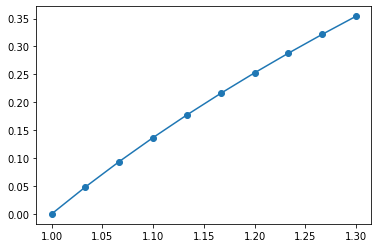

In [4]:
import numpy as np
from matplotlib import pyplot as plt

sample_params.set('mu_0',5)
sample_params.set('A0',0.1)
sample_params.set('L0',10)
applied_stretch = np.linspace(1,1.3,10)
force = sample.disp_controlled(applied_stretch,sample_params)
plt.plot(applied_stretch,force,'-o')
plt.show()

## Parameter fitting

If we have some force measurements (say from experiments), we can also do parameter fitting. We should fix the values of `A0` and `L0` to ensure a unique solution.

Parameter fitting instance created with the following settings
------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                10.00       Yes         -           -           
A0                0.10        Yes         -           -           
mu_0              5.00        No          1.00e-04    1.00e+02    
------------------------------------------------------------------

1 parameters will be fitted.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1049e-01                                    1.20e+01    
       1              2         2.2983e-02      3.88e-01       5.00e+00       2.62e+00    
       2              3         1.0599e-03      2.19e-02       1.48e+00       4.24e-02    
       3              4         1.0540e-03      5.94e-06       2.48e-02   

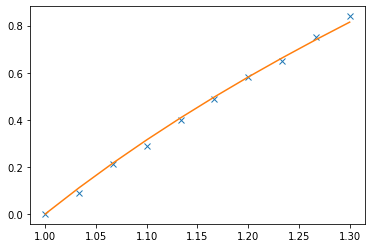

In [5]:
force_measured = np.array([0,0.09,0.21,0.29,0.4,0.49,0.58,0.65,0.75,0.84])
def sim_func(params):
    force_modeled = sample.disp_controlled(applied_stretch,params)
    return force_modeled

sample_params.fix('A0')
sample_params.fix('L0')
param_fitter = pmt.ParamFitter(sim_func,force_measured, sample_params)
param_fitter.fit()
print("Results after fitting")
print(sample_params)
plt.plot(applied_stretch,force_measured,'x')
plt.plot(applied_stretch,sim_func(sample_params),'-')
plt.show()

## Random Parameters: Monte Carlo simulation
We can also approach the problem probabilistically by treating the parameteres as random variables. Either we can generate samples `RandomParameters` and propagate them through the model (Monte Carlo simulation). 

Keys              Type              Lower/mean        Upper/std         
------------------------------------------------------------------------
L0                fixed             10.00             10.00             
A0                fixed             0.10              0.10              
mu_0              uniform           1.00e-04          1.00e+02          
------------------------------------------------------------------------

random_samples are a list of parameters dictionaries: <class 'list'> 300
results are of shape (300, 10)


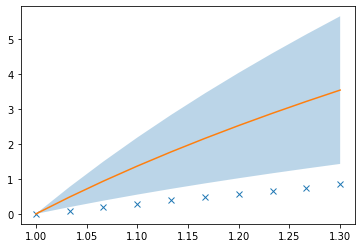

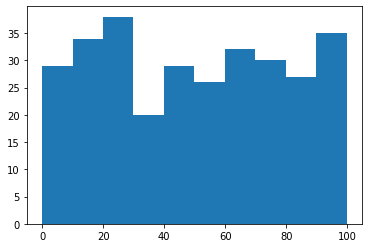

In [16]:
random_params = pmt.RandomParameters(sample_params)
print(random_params)
random_samples = random_params.sample(300)
print('random_samples are a list of parameters dictionaries:', type(random_samples),len(random_samples))
results = np.array([sim_func(s) for s in random_samples])
print('results are of shape', results.shape)

#We can plot the mean and variation of these
mean = np.mean(results,axis=0)
sd = np.std(results,axis=0)
plt.plot(applied_stretch,force_measured,'x')
plt.plot(applied_stretch,mean,'-')
plt.fill_between(applied_stretch,mean-sd,mean+sd,alpha=0.3)
plt.show()

mu_samples = [s['mu_0'] for s in random_samples]
plt.hist(mu_samples,bins=10)
plt.show()

## Random parameters: Markov Chain Monte Carlo simulation
Or we can perform a Markov Chain Monte Carlo (MCMC) simulation through some likelihood function. 

In [10]:
def prob(params):
    force_modeled = sample.disp_controlled(applied_stretch,params)
    diff = force_modeled - force_measured
    diff_norm2 = np.dot(diff,diff)
    var = 2.
    prob = np.exp(-diff_norm2/2./var) #in the case of MCMC we can skip the proportionality factor
    return prob,force_modeled

mcmc = pmt.MCMC(prob,sample_params)

MCMC instance created with the following settings
------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                10.00       Yes         -           -           
A0                0.10        Yes         -           -           
mu_0              12.86       No          1.00e-04    1.00e+02    
------------------------------------------------------------------

1 parameters will be varied.


In [13]:
mcmc.run(1000)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2324.23it/s]

MCMC sampling completed. Acceptance rate: 0.912
Number of samples: 912
To access the samples, use get_samples()


(912, 10)


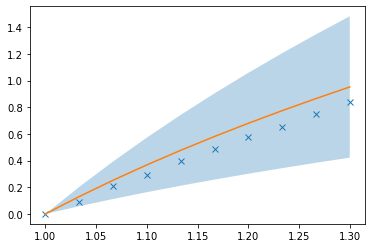

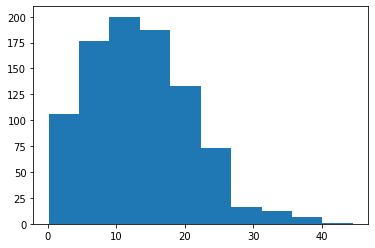

In [14]:
mcmc_samples = np.array(mcmc.get_samples()) #convert the list into an array
mcmc_probs = np.array(mcmc.get_probs()) #convert the list into an array
mcmc_force = np.array(mcmc.get_values()) #convert the list into an array
print(np.array(mcmc_force).shape)
#We can plot the mean and variation of these
mean = np.mean(mcmc_force,axis=0)
sd = np.std(mcmc_force,axis=0)
plt.plot(applied_stretch,force_measured,'x')
plt.plot(applied_stretch,mean,'-')
plt.fill_between(applied_stretch,mean-sd,mean+sd,alpha=0.3)
plt.show()

plt.hist(mcmc_samples)
plt.show()